### Predict Sahel rainfall with linear regression

In this project we work with **C**limate **I**ndex **C**ollection based on **Mo**del **D**ata (CICMoD) data set (https://github.com/MarcoLandtHayen/climate_index_collection). 

The task is to **reconstruct current** (lead 0) Sahel precipitation index (PREC_SAHEL) from the remaining indices. Additionally, we will try to **predict future** Sahel rainfall (lead times 1 / 3 / 6 months) from current information (lead 0) of all input features, including PREC_SAHEL. Here, we try linear regression as baseline:

- Prepare inputs and targets.
- Set up model.
- Evaluate model performance.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

### Import additional functions:
import sys
sys.path.append('../src')
from preprocessing import bar_color

### Prepare inputs and targets

- Load collection of climate indices directly from GitHub release.
- Create targets with desired lead times.
- Extract remaining indices as inputs.

In [2]:
# Set url:
data_url = (
    "https://github.com/MarcoLandtHayen/climate_index_collection/"
    "releases/download/v2023.03.29.1/climate_indices.csv"
)

# Load data:
climind = pd.read_csv(data_url)

# Format data:
climind = climind.set_index(["model", "year", "month", "index"]).unstack(level=-1)["value"]

In [3]:
# Separate data by model, reset index and drop columns year and month:
climind_FOCI = climind.loc[('FOCI')].reset_index().drop(columns=['year','month'])
climind_CESM = climind.loc[('CESM')].reset_index().drop(columns=['year','month'])

# Extract target series (PREC_SAHEL) and keep ALL indices (including PREC_SAHEL) as inputs:
target_FOCI = climind_FOCI.loc[:, climind_FOCI.columns == 'PREC_SAHEL']
target_CESM = climind_CESM.loc[:, climind_CESM.columns == 'PREC_SAHEL']
input_FOCI = climind_FOCI.loc[:]
input_CESM = climind_CESM.loc[:]

# Normalize target series to have zero mean and unit variance:
target_FOCI = (target_FOCI - np.mean(target_FOCI)) / np.std(target_FOCI)
target_CESM = (target_CESM - np.mean(target_CESM)) / np.std(target_CESM)

# Create targets with lead time 1, 3, 6 months:
target_FOCI_lead1 = target_FOCI[1:-5].values
target_FOCI_lead3 = target_FOCI[3:-3].values
target_FOCI_lead6 = target_FOCI[6:].values
target_CESM_lead1 = target_CESM[1:-5].values
target_CESM_lead3 = target_CESM[3:-3].values
target_CESM_lead6 = target_CESM[6:].values

# Erase last 6 rows from inputs and target, to keep dimensions right:
input_FOCI = input_FOCI[:-6]
input_CESM = input_CESM[:-6]
target_FOCI = target_FOCI[:-6]
target_CESM = target_CESM[:-6]

# Add targets with individual lead times as new columns:
target_FOCI['PREC_SAHEL_lead1'] = target_FOCI_lead1
target_FOCI['PREC_SAHEL_lead3'] = target_FOCI_lead3
target_FOCI['PREC_SAHEL_lead6'] = target_FOCI_lead6
target_CESM['PREC_SAHEL_lead1'] = target_CESM_lead1
target_CESM['PREC_SAHEL_lead3'] = target_CESM_lead3
target_CESM['PREC_SAHEL_lead6'] = target_CESM_lead6

# Check dimensions:
print("FOCI inputs shape (time steps, features): ", input_FOCI.shape)
print("CESM inputs shape (time steps, features): ", input_CESM.shape)
print("\nFOCI target shape (time steps, features): ", target_FOCI.shape)
print("CESM target shape (time steps, features): ", target_CESM.shape)

FOCI inputs shape (time steps, features):  (11994, 29)
CESM inputs shape (time steps, features):  (11982, 29)

FOCI target shape (time steps, features):  (11994, 4)
CESM target shape (time steps, features):  (11982, 4)


### Check correlation

Next we check, how input features correlate to targets with different lead times.

<AxesSubplot:title={'center':'Pairwise correlation of input features and target series with different lead times (FOCI)'}, xlabel='index', ylabel='index'>

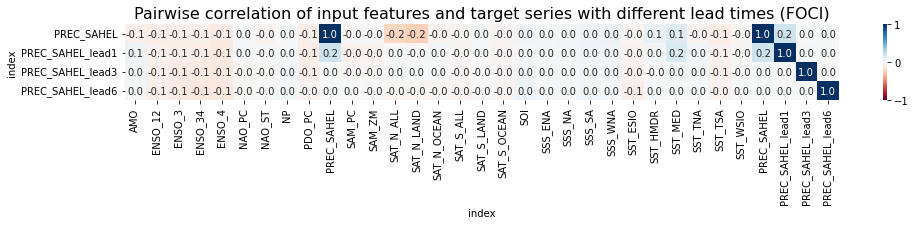

In [4]:
# Plot correlation of inputs and target series as heatmap:
fig, ax = plt.subplots(figsize=(16,1.4))
plt.title('Pairwise correlation of input features and target series with different lead times (FOCI)', fontsize=16)
sns.heatmap(
    pd.concat([input_FOCI, target_FOCI[['PREC_SAHEL', 'PREC_SAHEL_lead1', 'PREC_SAHEL_lead3', 'PREC_SAHEL_lead6']]], axis=1).corr()[-4:], 
    cmap="RdBu",
    xticklabels=True, 
    yticklabels=True,
    center=0,
    vmin=-1,
    vmax=1,
    annot=True,
    fmt=".1f",
)

### Discussion on correlation check

Find inputs and targets to be **mostly un-correlated**. If at all, we see some minor negative correlation between SAT anomaly indices (SAT_N_ALL and SAT_N_LAND) and Sahel Precipitation index (PREC_SAHEL). Correlation coefficient reads -0.2.

We also find a low level of **auto correlation**: Correlation of original PREC_SAHEL and targets with lead time 1 / 3 / 6 months reads 0.2 / 0.0 / 0.0, respectively.

### Continue data pre-processing

We now continue to prepare inputs and targets:

- Split inputs and targets into train and test sets.
- Optionally scale or normalize inputs according to statistics obtained only from train data.

In [5]:
## Set parameters for inputs and target:

# Select input features:
input_features = [
    'AMO', 'ENSO_12', 'ENSO_3', 'ENSO_34', 'ENSO_4', 'NAO_PC', 'NAO_ST', 
    'NP', 'PDO_PC', 'PREC_SAHEL', 'SAM_PC', 'SAM_ZM', 'SAT_N_ALL', 'SAT_N_LAND',
    'SAT_N_OCEAN', 'SAT_S_ALL', 'SAT_S_LAND', 'SAT_S_OCEAN', 'SOI',
    'SSS_ENA', 'SSS_NA', 'SSS_SA', 'SSS_WNA', 'SST_ESIO', 'SST_HMDR',
    'SST_MED', 'SST_TNA', 'SST_TSA', 'SST_WSIO'
]

# Specify relative amount of train data:
train_val_split = 0.9

## Optionally choose to scale or normalize input features:
# 'no': Keep raw input features.
# 'scale_01': Scale input features with min/max scaling to [0,1].
# 'scale_11': Scale input features with min/max scaling to [-1,1].
# 'norm': Normalize input features, hence subtract mean and divide by std dev.
scale_norm = 'norm'

In [6]:
# Select specified input features:
input_selected_FOCI = input_FOCI[input_features]
input_selected_CESM = input_CESM[input_features]

In [7]:
## Split inputs and targets into train and test sets:

# Get number of train samples:
n_train = int(train_val_split * len(input_selected_FOCI))

# Split inputs and targets:
train_input_FOCI = input_selected_FOCI[:n_train]
train_input_CESM = input_selected_CESM[:n_train]
test_input_FOCI = input_selected_FOCI[n_train:]
test_input_CESM = input_selected_CESM[n_train:]

train_target_FOCI = target_FOCI[:n_train]
train_target_CESM = target_CESM[:n_train]
test_target_FOCI = target_FOCI[n_train:]
test_target_CESM = target_CESM[n_train:]

# Check dimensions:
print("FOCI: train_input shape (samples, features): ", train_input_FOCI.shape)
print("FOCI_test_input shape (samples, features): ", test_input_FOCI.shape)
print("CESM: train_input shape (samples, features): ", train_input_CESM.shape)
print("CESM_test_input shape (samples, features): ", test_input_CESM.shape)
print("\nFOCI: train_target shape (samples, features): ", train_target_FOCI.shape)
print("FOCI: test_target shape (samples, features): ", test_target_FOCI.shape)
print("CESM train_target shape (samples, features): ", train_target_CESM.shape)
print("CESM: test_target shape (samples, features): ", test_target_CESM.shape)

FOCI: train_input shape (samples, features):  (10794, 29)
FOCI_test_input shape (samples, features):  (1200, 29)
CESM: train_input shape (samples, features):  (10794, 29)
CESM_test_input shape (samples, features):  (1188, 29)

FOCI: train_target shape (samples, features):  (10794, 4)
FOCI: test_target shape (samples, features):  (1200, 4)
CESM train_target shape (samples, features):  (10794, 4)
CESM: test_target shape (samples, features):  (1188, 4)


In [8]:
## Get statistics from train data:

# Get mean, std dev, min and max for ALL input features from train data:
train_mean_FOCI = np.mean(train_input_FOCI, axis=0)
train_std_FOCI = np.std(train_input_FOCI, axis=0)
train_min_FOCI = np.min(train_input_FOCI, axis=0)
train_max_FOCI = np.max(train_input_FOCI, axis=0)
train_mean_CESM = np.mean(train_input_CESM, axis=0)
train_std_CESM = np.std(train_input_CESM, axis=0)
train_min_CESM = np.min(train_input_CESM, axis=0)
train_max_CESM = np.max(train_input_CESM, axis=0)

## Optionally scale or normalize input features as specified:

# 'scale_01': Scale input features with min/max scaling to [0,1].
if scale_norm == "scale_01":
    train_input_scaled_FOCI = (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    test_input_scaled_FOCI = (test_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI)
    train_input_scaled_CESM = (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)
    test_input_scaled_CESM = (test_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM)

# 'scale_11': Scale input features with min/max scaling to [-1,1].
if scale_norm == "scale_11":
    train_input_scaled_FOCI = 2 * (train_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1
    test_input_scaled_FOCI = 2 * (test_input_FOCI - train_min_FOCI) / (train_max_FOCI - train_min_FOCI) - 1 
    train_input_scaled_CESM = 2 * (train_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1
    test_input_scaled_CESM = 2 * (test_input_CESM - train_min_CESM) / (train_max_CESM - train_min_CESM) - 1

# 'norm': Normalize input features, hence subtract mean and divide by std dev.
if scale_norm == "norm":
    train_input_scaled_FOCI = (train_input_FOCI - train_mean_FOCI) / train_std_FOCI
    test_input_scaled_FOCI = (test_input_FOCI - train_mean_FOCI) / train_std_FOCI
    train_input_scaled_CESM = (train_input_CESM - train_mean_CESM) / train_std_CESM
    test_input_scaled_CESM = (test_input_CESM - train_mean_CESM) / train_std_CESM

# else: Keep raw input features.

# Check result:
print("FOCI: train_input MIN: ", np.round(np.min(train_input_scaled_FOCI, axis=0), 2))
print("FOCI: train_input MAX: ", np.round(np.max(train_input_scaled_FOCI, axis=0), 2))
print("FOCI: train_input MEAN: ", np.round(np.mean(train_input_scaled_FOCI, axis=0), 2))
print("FOCI: train_input STD: ", np.round(np.std(train_input_scaled_FOCI, axis=0), 2))
print("FOCI: test_input MIN: ", np.round(np.min(test_input_scaled_FOCI, axis=0), 2))
print("FOCI: test_input MAX: ", np.round(np.max(test_input_scaled_FOCI, axis=0), 2))
print("FOCI: test_input MEAN: ", np.round(np.mean(test_input_scaled_FOCI, axis=0), 2))
print("FOCI: test_input STD: ", np.round(np.std(test_input_scaled_FOCI, axis=0), 2))
print("\n\nCESM: train_input MIN: ", np.round(np.min(train_input_scaled_CESM, axis=0), 2))
print("CESM: train_input MAX: ", np.round(np.max(train_input_scaled_CESM, axis=0), 2))
print("CESM: train_input MEAN: ", np.round(np.mean(train_input_scaled_CESM, axis=0), 2))
print("CESM: train_input STD: ", np.round(np.std(train_input_scaled_CESM, axis=0), 2))
print("CESM: test_input MIN: ", np.round(np.min(test_input_scaled_CESM, axis=0), 2))
print("CESM: test_input MAX: ", np.round(np.max(test_input_scaled_CESM, axis=0), 2))
print("CESM: test_input MEAN: ", np.round(np.mean(test_input_scaled_CESM, axis=0), 2))
print("CESM: test_input STD: ", np.round(np.std(test_input_scaled_CESM, axis=0), 2))

FOCI: train_input MIN:  index
AMO           -3.41
ENSO_12       -3.82
ENSO_3        -4.05
ENSO_34       -3.10
ENSO_4        -3.16
NAO_PC        -3.75
NAO_ST        -3.83
NP            -4.13
PDO_PC        -3.63
PREC_SAHEL    -5.22
SAM_PC        -4.00
SAM_ZM        -4.20
SAT_N_ALL     -4.41
SAT_N_LAND    -4.58
SAT_N_OCEAN   -4.26
SAT_S_ALL     -4.80
SAT_S_LAND    -4.51
SAT_S_OCEAN   -4.51
SOI           -4.13
SSS_ENA       -3.37
SSS_NA        -3.44
SSS_SA        -3.78
SSS_WNA       -4.02
SST_ESIO      -3.76
SST_HMDR      -4.03
SST_MED       -4.70
SST_TNA       -3.81
SST_TSA       -4.21
SST_WSIO      -4.36
dtype: float64
FOCI: train_input MAX:  index
AMO             4.10
ENSO_12         4.60
ENSO_3          4.38
ENSO_34         4.66
ENSO_4          3.26
NAO_PC          4.82
NAO_ST          4.38
NP              4.20
PDO_PC          3.75
PREC_SAHEL     11.98
SAM_PC          2.96
SAM_ZM          2.81
SAT_N_ALL       4.43
SAT_N_LAND      3.84
SAT_N_OCEAN     4.25
SAT_S_ALL       3.86
SAT_S_LAN

### Try linear regression on FOCI and CESM data to set the benchmark

#### Nomenclature and mathematical background on linear regression

We apply multi-linear regression and use **remaining indices as predictors** to predict **Sahel precipitation anomaly index** with various lead times (0 / 1 / 3 / 6 months). 

Inputs have dimension (samples, features), targets have timension (samples, 1). We are looking for weights $W$ with shape (features, 1) and bias $b$ as single value.

The relation between train inputs $U$, weights, bias and train targets $Y$ reads:

$$U \cdot W + \overline{b} = Y$$

Note: Here $\overline{b}$ denotes a vector of shape (samples, 1), containing only the constant bias value.

We switch to "augmented" notation and include ${b}$ as additional weight in $W$. This requires to add a column of *ones* as last column of $U$, for keeping dimensions right. This leads to:

$$U' \cdot W' = Y$$

where $U'$ and $W'$ denote train inputs and weights in augmented notation, respectively. 

Solving for $W'$ we need to invert $U'$, or get the pseudo-inverse $U'_{inv}$, since $U'$ is usually not a square matrix:

$$W' = U'_{inv} \cdot Y$$

Doing this, we obtain trained weights (including biases) and stick to augmented notation. To get predictions on validation inputs we also need to add a column of *ones* as last column to validation inputs.

In [9]:
## Linear regression on FOCI and CESM data.

# Loop over lead times:
for l in range(train_target_FOCI.shape[-1]):

    # Create vector of shape (samples, 1) containing ONEs to be added as additional column to train and test inputs.
    train_input_add_FOCI = np.ones((train_input_FOCI.shape[0], 1))
    train_input_add_CESM = np.ones((train_input_CESM.shape[0], 1))
    test_input_add_FOCI = np.ones((test_input_FOCI.shape[0], 1))
    test_input_add_CESM = np.ones((test_input_CESM.shape[0], 1))

    # Now add vector of ONEs as additional column to train and validation inputs, omit time dimension:
    train_input_prime_FOCI = np.concatenate((train_input_FOCI.values[:,:], train_input_add_FOCI), axis=-1)
    train_input_prime_CESM = np.concatenate((train_input_CESM.values[:,:], train_input_add_CESM), axis=-1)
    test_input_prime_FOCI = np.concatenate((test_input_FOCI.values[:,:], test_input_add_FOCI), axis=-1)
    test_input_prime_CESM = np.concatenate((test_input_CESM.values[:,:], test_input_add_CESM), axis=-1)

    # Then need pseudo-inverse of train inputs in augmented notation:
    train_input_prime_inv_FOCI = np.linalg.pinv(train_input_prime_FOCI)
    train_input_prime_inv_CESM = np.linalg.pinv(train_input_prime_CESM)

    # Train weights on FOCI targets with current lead time l:
    W_prime_FOCI = np.matmul(train_input_prime_inv_FOCI, train_target_FOCI.values[:,l])
    W_prime_CESM = np.matmul(train_input_prime_inv_CESM, train_target_CESM.values[:,l])

    # Store model predictions and trained weights for all lead times.
    # For l=0, need to initialize storage:
    if l==0:
        
        # Extract weights and bias from augmented notation (W_prime), the last value is the bias:
        W_FOCI = np.expand_dims(W_prime_FOCI[:-1],axis=1)        
        W_CESM = np.expand_dims(W_prime_CESM[:-1],axis=1)
        
        # Get model predictions on train and validation data:
        train_pred_linReg_FOCI = np.expand_dims(np.matmul(train_input_prime_FOCI, W_prime_FOCI),axis=1)
        train_pred_linReg_CESM = np.expand_dims(np.matmul(train_input_prime_CESM, W_prime_CESM),axis=1)
        test_pred_linReg_FOCI = np.expand_dims(np.matmul(test_input_prime_FOCI, W_prime_FOCI),axis=1)
        test_pred_linReg_CESM = np.expand_dims(np.matmul(test_input_prime_CESM, W_prime_CESM),axis=1)
    
    # For l>0: Combine current prediction with former predictions.
    else:
        
        # Extract weights and bias from augmented notation (W_prime), the last value is the bias:
        W_FOCI = np.concatenate([W_FOCI,np.expand_dims(W_prime_FOCI[:-1],axis=1)],axis=1)
        W_CESM = np.concatenate([W_CESM,np.expand_dims(W_prime_CESM[:-1],axis=1)],axis=1)
        
        # Get model predictions on train and validation data and stack:
        train_pred_linReg_FOCI = np.concatenate([train_pred_linReg_FOCI,np.expand_dims(np.matmul(train_input_prime_FOCI, W_prime_FOCI),axis=1)],axis=1)
        train_pred_linReg_CESM = np.concatenate([train_pred_linReg_CESM,np.expand_dims(np.matmul(train_input_prime_CESM, W_prime_CESM),axis=1)],axis=1)
        test_pred_linReg_FOCI = np.concatenate([test_pred_linReg_FOCI,np.expand_dims(np.matmul(test_input_prime_FOCI, W_prime_FOCI),axis=1)],axis=1)
        test_pred_linReg_CESM = np.concatenate([test_pred_linReg_CESM,np.expand_dims(np.matmul(test_input_prime_CESM, W_prime_CESM),axis=1)],axis=1)
    
    

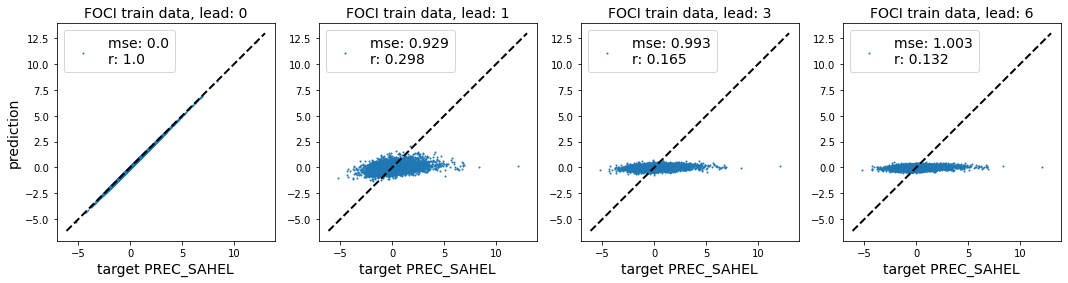

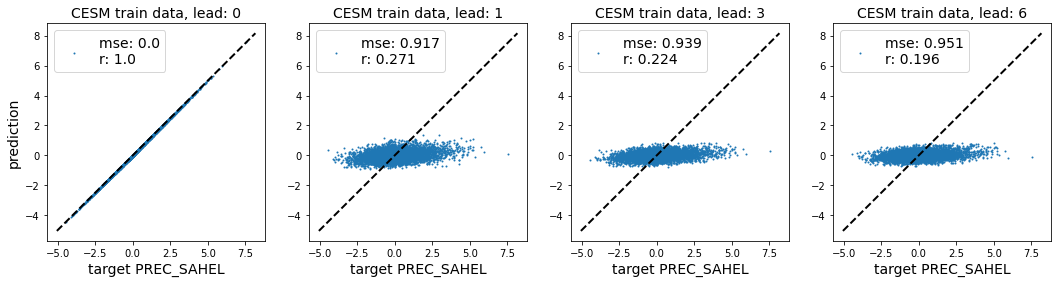

In [10]:
## Show scatterplot of Sahel rainfall obtained from model predictions vs. true targets.
## TRAIN data:

# Define short names for lead times:
lead_times_short = ['lead: 0', 'lead: 1', 'lead: 3', 'lead: 6']

# Initialize plot for FOCI:
fig, axes = plt.subplots(1,len(lead_times_short),figsize=(18,4))

# Loop over lead times:
for l in range(len(lead_times_short)):
    
    axes[l].scatter(train_target_FOCI.values[:,l], train_pred_linReg_FOCI[:,l], s=1,
                   label='mse: '+
                    str(np.round(np.mean((train_target_FOCI.values[:,l] - train_pred_linReg_FOCI[:,l])**2),3))+'\nr: '+
                    str(np.round(np.corrcoef(np.stack([train_target_FOCI.values[:,l],train_pred_linReg_FOCI[:,l]]))[0,1],3))
                   )
    axes[l].legend(fontsize=14)
    axes[l].set_title('FOCI train data, '+lead_times_short[l], fontsize=14)
    axes[l].set_xlabel('target PREC_SAHEL', fontsize=14)
    axes[0].set_ylabel('prediction', fontsize=14)
    
    x = np.linspace(*axes[l].get_xlim())
    axes[l].plot(x, x, linestyle='--', color='k', lw=2)
    
    
# Initialize plot for CESM:
fig, axes = plt.subplots(1,len(lead_times_short),figsize=(18,4))

# Loop over lead times:
for l in range(len(lead_times_short)):
    
    axes[l].scatter(train_target_CESM.values[:,l], train_pred_linReg_CESM[:,l], s=1,
                   label='mse: '+
                    str(np.round(np.mean((train_target_CESM.values[:,l] - train_pred_linReg_CESM[:,l])**2),3))+'\nr: '+
                    str(np.round(np.corrcoef(np.stack([train_target_CESM.values[:,l],train_pred_linReg_CESM[:,l]]))[0,1],3))
                   )
    axes[l].legend(fontsize=14)
    axes[l].set_title('CESM train data, '+lead_times_short[l], fontsize=14)
    axes[l].set_xlabel('target PREC_SAHEL', fontsize=14)
    axes[0].set_ylabel('prediction', fontsize=14)
    
    x = np.linspace(*axes[l].get_xlim())
    axes[l].plot(x, x, linestyle='--', color='k', lw=2)

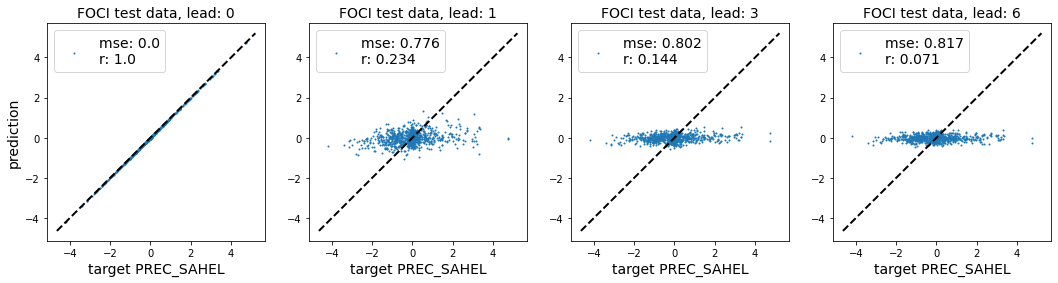

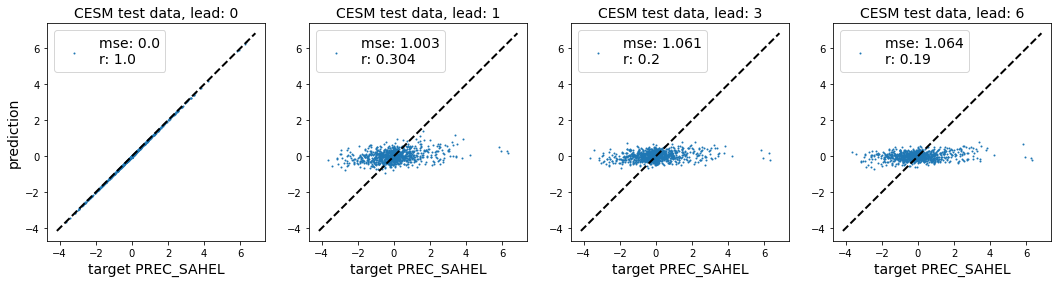

In [11]:
## Show scatterplot of Sahel rainfall obtained from model predictions vs. true targets.
## TEST data:

# Define short names for lead times:
lead_times_short = ['lead: 0', 'lead: 1', 'lead: 3', 'lead: 6']

# Initialize plot for FOCI:
fig, axes = plt.subplots(1,len(lead_times_short),figsize=(18,4))

# Loop over lead times:
for l in range(len(lead_times_short)):
    
    axes[l].scatter(test_target_FOCI.values[:,l], test_pred_linReg_FOCI[:,l], s=1,
                   label='mse: '+
                    str(np.round(np.mean((test_target_FOCI.values[:,l] - test_pred_linReg_FOCI[:,l])**2),3))+'\nr: '+
                    str(np.round(np.corrcoef(np.stack([test_target_FOCI.values[:,l],test_pred_linReg_FOCI[:,l]]))[0,1],3))
                   )
    axes[l].legend(fontsize=14)
    axes[l].set_title('FOCI test data, '+lead_times_short[l], fontsize=14)
    axes[l].set_xlabel('target PREC_SAHEL', fontsize=14)
    axes[0].set_ylabel('prediction', fontsize=14)
    
    x = np.linspace(*axes[l].get_xlim())
    axes[l].plot(x, x, linestyle='--', color='k', lw=2)
    


# Initialize plot for CESM:
fig, axes = plt.subplots(1,len(lead_times_short),figsize=(18,4))

# Loop over lead times:
for l in range(len(lead_times_short)):
    
    axes[l].scatter(test_target_CESM.values[:,l], test_pred_linReg_CESM[:,l], s=1,
                   label='mse: '+
                    str(np.round(np.mean((test_target_CESM.values[:,l] - test_pred_linReg_CESM[:,l])**2),3))+'\nr: '+
                    str(np.round(np.corrcoef(np.stack([test_target_CESM.values[:,l],test_pred_linReg_CESM[:,l]]))[0,1],3))
                   )
    axes[l].legend(fontsize=14)
    axes[l].set_title('CESM test data, '+lead_times_short[l], fontsize=14)
    axes[l].set_xlabel('target PREC_SAHEL', fontsize=14)
    axes[0].set_ylabel('prediction', fontsize=14)
    
    x = np.linspace(*axes[l].get_xlim())
    axes[l].plot(x, x, linestyle='--', color='k', lw=2)

Text(0.5, 0, 'Time [month]')

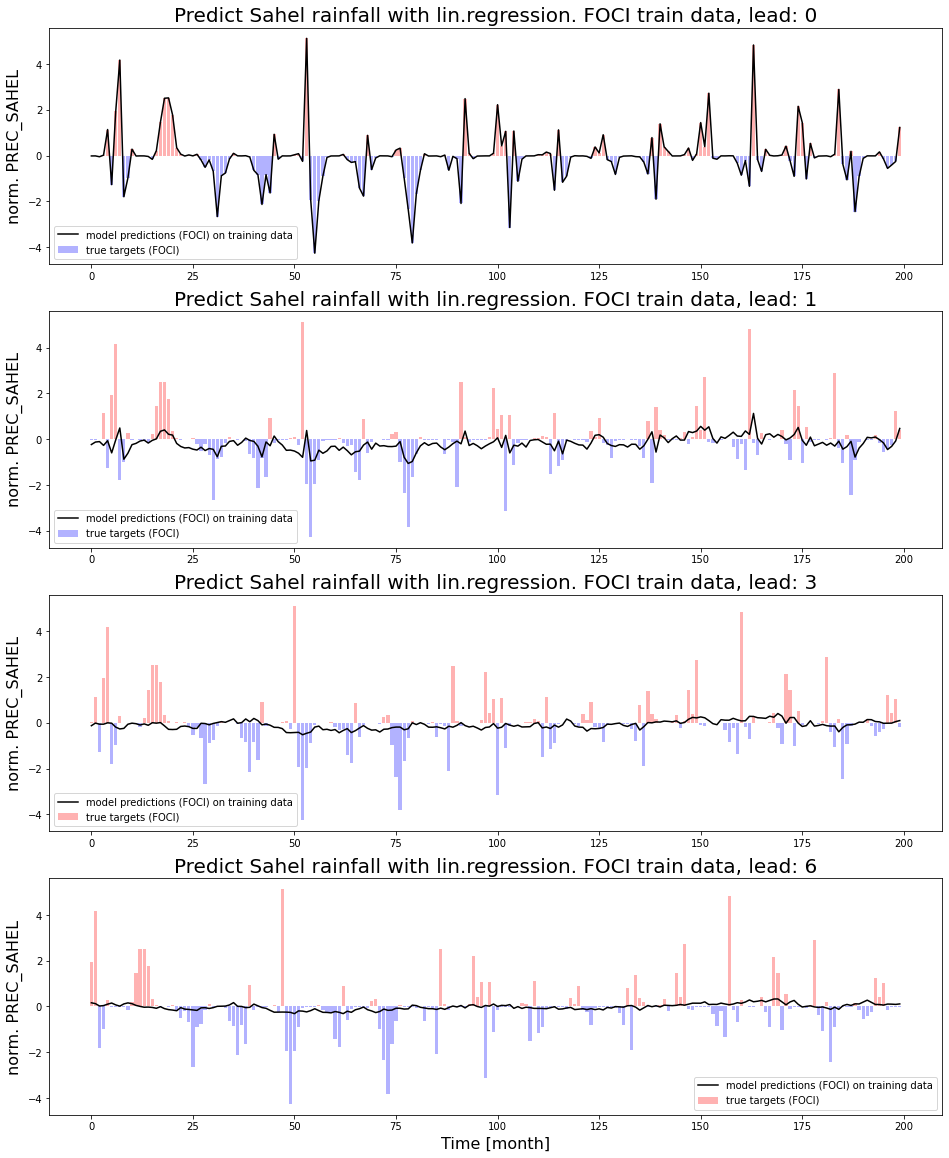

In [12]:
## Fidelity check: Plot TRAIN targets as bar plot (red / blue) vs. predictions as black line

## FOCI:
fig, axes = plt.subplots(len(lead_times_short),1,figsize=[16,20])

# Loop over lead times:
for l in range(len(lead_times_short)):
    
    axes[l].bar(
    x=range(len(train_target_FOCI.values[:200,l])),
    height=train_target_FOCI.values[:200,l],
    color=bar_color(train_target_FOCI[:200],'r','b')[l],
    label="true targets (FOCI)",
    alpha=0.3
    )
    
    axes[l].plot(train_pred_linReg_FOCI[:200,l], label="model predictions (FOCI) on training data", color='black')
    axes[l].legend()
    
    axes[l].set_title('Predict Sahel rainfall with lin.regression. FOCI train data, '+lead_times_short[l], fontsize=20)
    axes[l].set_ylabel('norm. PREC_SAHEL', fontsize=16)

axes[len(lead_times_short)-1].set_xlabel('Time [month]', fontsize=16)

Text(0.5, 0, 'Time [month]')

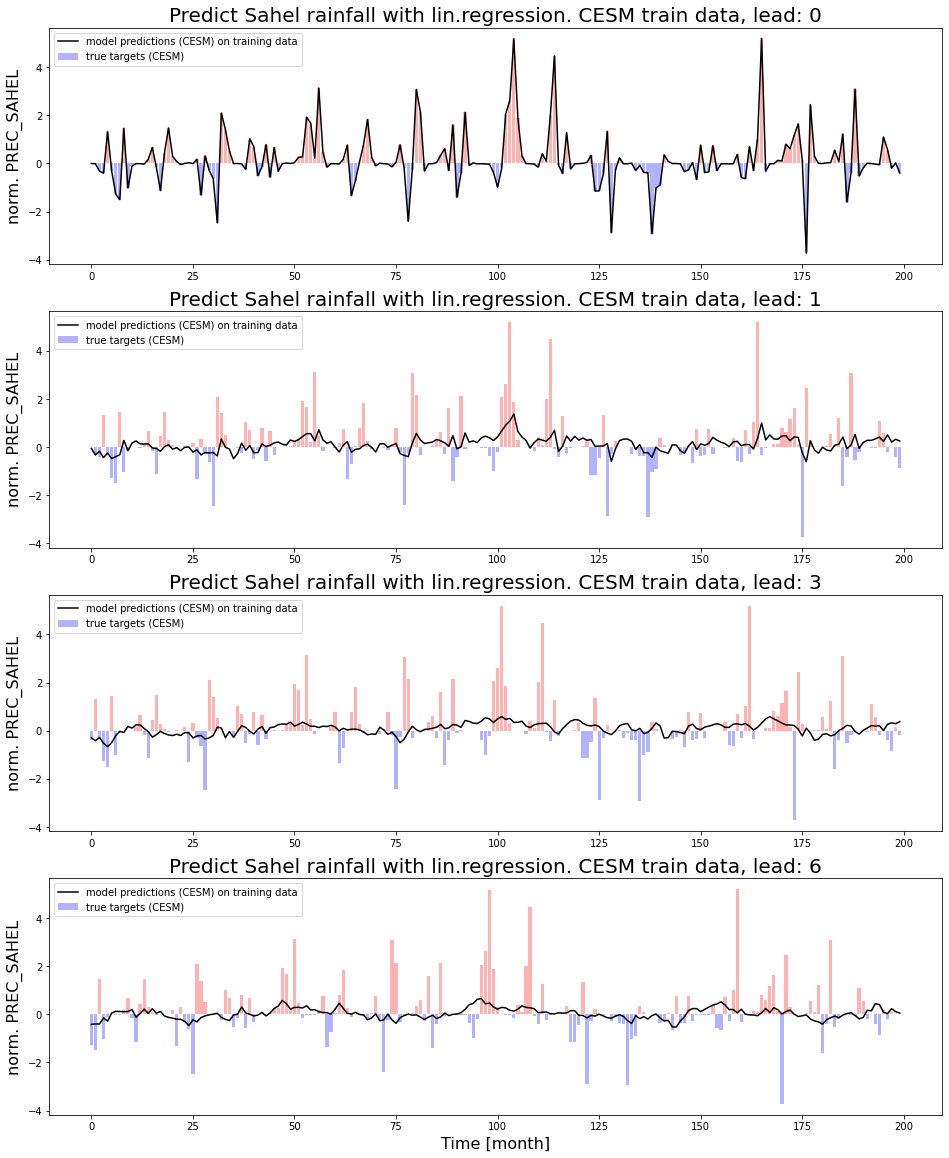

In [13]:
## Fidelity check: Plot TRAIN targets as bar plot (red / blue) vs. predictions as black line

## CESM:
fig, axes = plt.subplots(len(lead_times_short),1,figsize=[16,20])

# Loop over lead times:
for l in range(len(lead_times_short)):
    
    axes[l].bar(
    x=range(len(train_target_CESM.values[:200,l])),
    height=train_target_CESM.values[:200,l],
    color=bar_color(train_target_CESM[:200],'r','b')[l],
    label="true targets (CESM)",
    alpha=0.3
    )
    
    axes[l].plot(train_pred_linReg_CESM[:200,l], label="model predictions (CESM) on training data", color='black')
    axes[l].legend()
    
    axes[l].set_title('Predict Sahel rainfall with lin.regression. CESM train data, '+lead_times_short[l], fontsize=20)
    axes[l].set_ylabel('norm. PREC_SAHEL', fontsize=16)

axes[len(lead_times_short)-1].set_xlabel('Time [month]', fontsize=16)

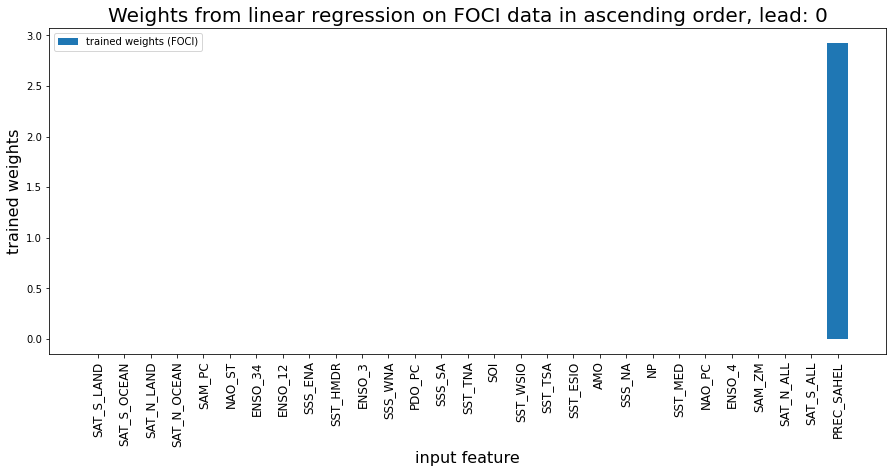

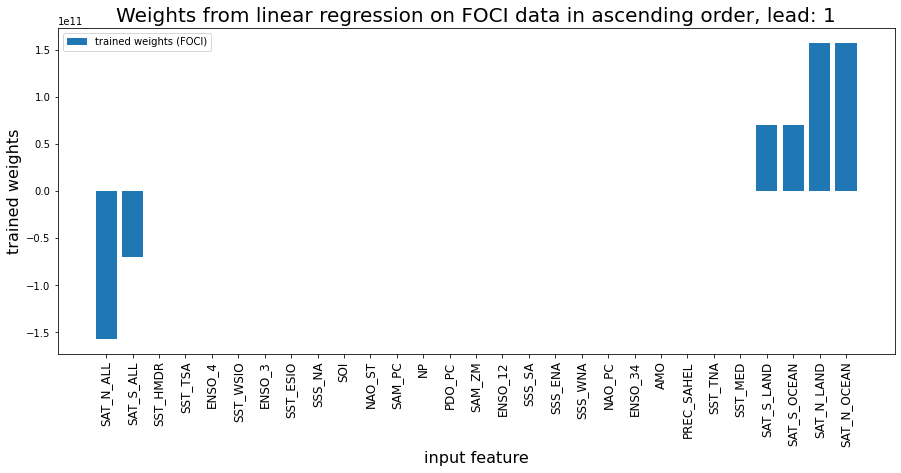

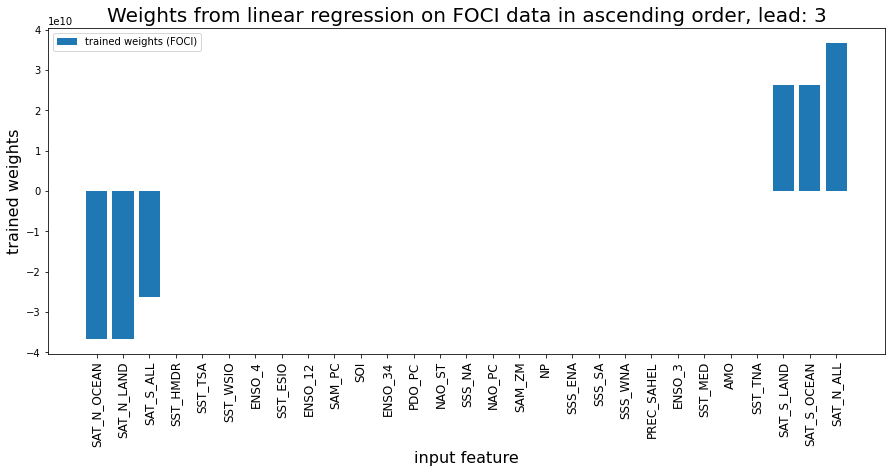

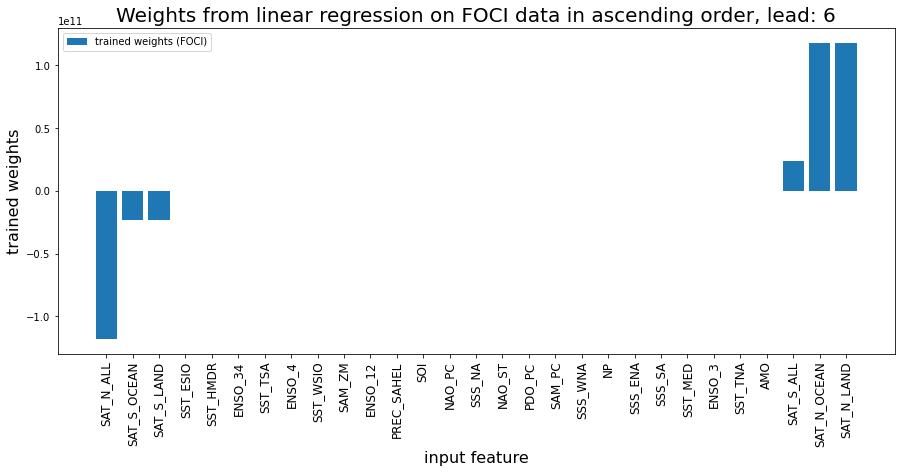

In [14]:
## Plot trained weights in ascending order:
## FOCI

# Loop over lead times:
for l in range(len(lead_times_short)):

    # Plot trained weights for current lead time:
    fig, ax = plt.subplots(1,1,figsize=[15,6])
    ax.bar(
        x=range(len(W_FOCI[:,l])),
        height=W_FOCI[:,l][np.argsort(W_FOCI[:,l])],
        label="trained weights (FOCI)",
    )
    ax.legend()
    ax.set_title('Weights from linear regression on FOCI data in ascending order, '+lead_times_short[l], fontsize=20)
    ax.set_xlabel('input feature', fontsize=16)
    ax.set_ylabel('trained weights', fontsize=16)
    plt.xticks(range(len(W_FOCI[:,l])), input_FOCI.columns.values[np.argsort(W_FOCI[:,l])], fontsize=12, rotation=90)

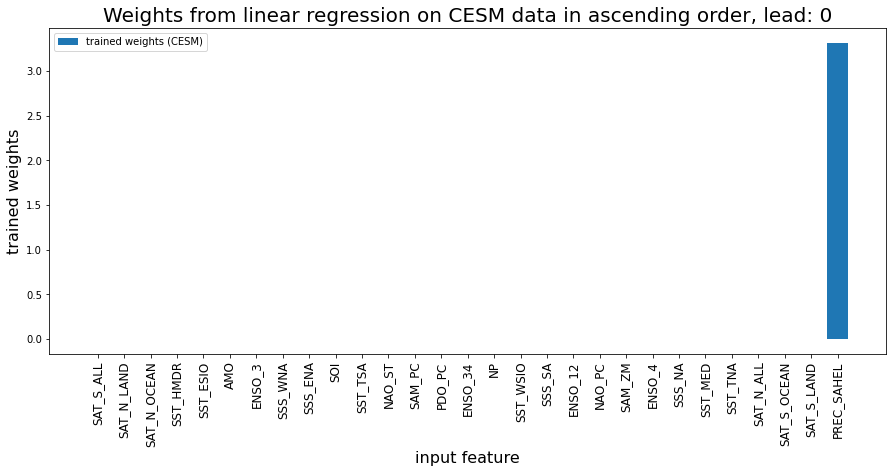

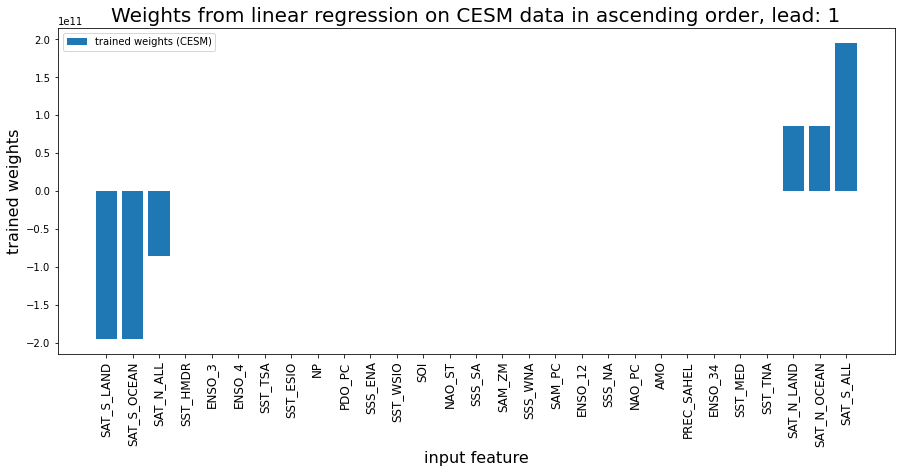

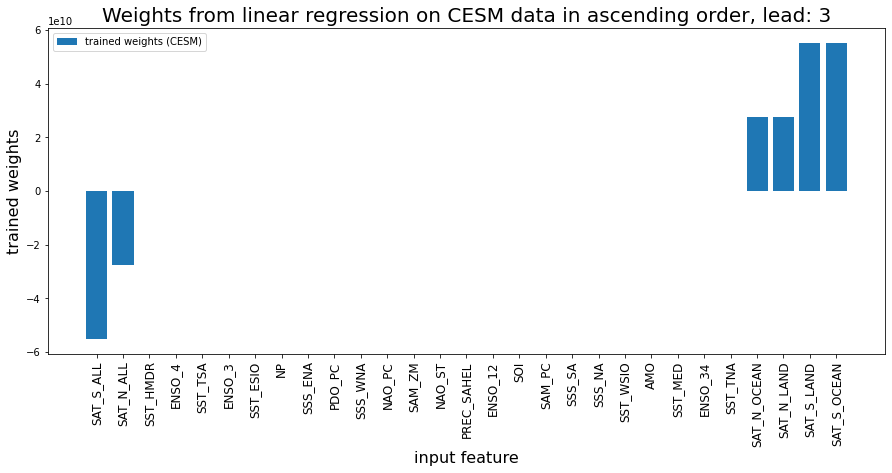

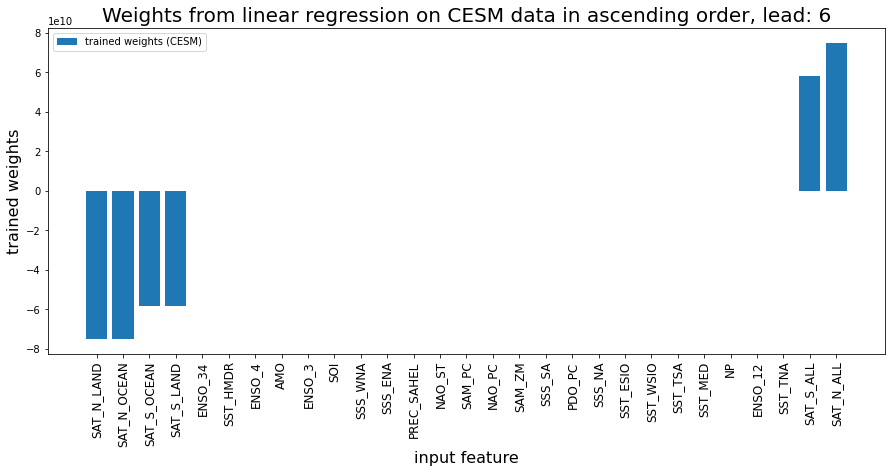

In [15]:
## Plot trained weights in ascending order:
## CESM

# Loop over lead times:
for l in range(len(lead_times_short)):

    # Plot trained weights for current lead time:
    fig, ax = plt.subplots(1,1,figsize=[15,6])
    ax.bar(
        x=range(len(W_CESM[:,l])),
        height=W_CESM[:,l][np.argsort(W_CESM[:,l])],
        label="trained weights (CESM)",
    )
    ax.legend()
    ax.set_title('Weights from linear regression on CESM data in ascending order, '+lead_times_short[l], fontsize=20)
    ax.set_xlabel('input feature', fontsize=16)
    ax.set_ylabel('trained weights', fontsize=16)
    plt.xticks(range(len(W_CESM[:,l])), input_CESM.columns.values[np.argsort(W_CESM[:,l])], fontsize=12, rotation=90)

### Discussion: Linear regression results

In this experiment, we allowed historic information for PREC_SAHEL as input feature to predict future Sahel precipitation (lead 1 / 3 / 6 months).

As we saw, we have a low level of auto correlation between original PREC_SAHEL index and targets (lead 1 / 3 / 6 months). Only for lead time 1 months, we have a small correlation of 0.2.

This reflects in the results: Only for this lead time (1 month), we find slightly improved prediction accuracy in terms of a slightly lower mse and higher correlation of predicted vs. true targets. Results further into the future (lead 3 / 6 months) are unchanged, compared to former experiments *without* current PREC_SAHEL as input feature.